# Testing Computational Costs

In [6]:
import numpy as np
import timeit
import matplotlib.pyplot as plt

---
## Simulating Data

In [7]:
def simulate_dataset(samples, features, beta_values):
    np.random.seed(42) # random seed for reproducability

    # generating random X values based on samples and features
    X = np.random.uniform(0, 1, (samples, features))

    # column vector of ones for intercept
    ones = np.ones(len(X))

    # adding column of ones to feature matrix
    X = np.c_[ones, X]

    # generating random noise values
    epsilon = np.random.normal(0, 1, samples)

    # calculating y based on X dot multiplied with beta vector (note beta_0 multiplied by ones from the added column)
    # adding epsilon for some random variance
    y = np.dot(X, beta_values) + epsilon
    y = y.reshape(-1, 1) # giving y the dimensions (1000,1) instead of (1000,)
    
    return X, y

---
## Algorithms

In [8]:
def gradient_descent(X, y, learning_rate = 0.1, epochs = 500):
    m = len(X)

    # array of random values with equal amount of rows as X has columns (X.shape[1]), and 1 column
    # for example X (1000, 3) -> theta (3, 1)
    theta = np.random.randn(X.shape[1], 1)

    # looping over epochs
    for _ in range(epochs):

        # calculating gradient
        gradient = 2 / m * X.T @ (X @ theta - y)

        # updating theta based on learning rate and gradient
        theta -= learning_rate * gradient
        
    return theta

In [9]:
def stochastic_gradient_descent(X, y, learning_rate = 0.1, epochs = 10):
    np.random.seed(42)

    m = len(X)

    theta = np.random.randn(X.shape[1], 1)

    for epoch in range(epochs):
        for i in range(m):
            
            # taking random 1-size slices from X and y
            random_index = np.random.randint(m)
            x_i = X[random_index:random_index + 1]
            y_i = y[random_index:random_index + 1]

            gradients = 2 * x_i.T @ (x_i @ (theta) - y_i)

            # decaying learning rate
            # t = epoch * m + i
            # eta = t0 / (t + t1)

            theta -= learning_rate * gradients

    return theta


In [10]:
def mini_batch_gradient_descent(X, y, learning_rate = 0.1, epochs = 100, batch_size = 32):
    m = len(X)
    batches = m // batch_size # number of batches per epoch
    theta = np.random.randn(X.shape[1], 1)

    for epoch in range(epochs):

        # Shuffle the training data
        permutation = np.random.permutation(m)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        for i in range(batches):
            start_index = i * batch_size
            end_index = start_index + batch_size

            X_batch = X_shuffled[start_index : end_index]
            y_batch = y_shuffled[start_index : end_index]

            gradient = 2 / m * X_batch.T @ (X_batch @ theta - y_batch)

            theta -= learning_rate * gradient
    
    return theta


---
## Time Function

### Function for using timeit to see how long a certain algorithm takes to run

In [11]:
def time_gradient_descent(samples_list, features_list, algorithm, learning_rate = 0.1, epochs = 100):
    time_list = []

    # repeat for each amount of features and samples in respective list
    for samples, features in zip(samples_list, features_list):

        # first generate some X and y data
        beta_values = [1] * (features + 1)
        X, y = simulate_dataset(samples, features, beta_values)

        # start a timer
        start_time = timeit.default_timer()

        # run gradient descent
        if algorithm == "gradient":
            theta = gradient_descent(X, y, learning_rate, epochs)
        if algorithm == "stochastic":
            theta = stochastic_gradient_descent(X, y, learning_rate, epochs)
        if algorithm == "mini-batch":
            theta = mini_batch_gradient_descent(X, y, learning_rate, epochs)

        # add time taken since timer started to list
        time_list.append(timeit.default_timer()-start_time)
    
    # return list of time taken for each amount of features and samples
    return time_list

---
## Defining Plotting Functions

### Function for plotting a single algorithm

In [12]:
def plot_time(ax, samples_list, features_list, algorithm, stop, learning_rate = 0.1, epochs = 100):
    features = [50] * len(samples_list)
    increasing_samples = time_gradient_descent(samples_list, features, algorithm, learning_rate, epochs)

    samples = [50] * len(features_list)
    increasing_features = time_gradient_descent(samples, features_list, algorithm, learning_rate, epochs)

    ax.plot(increasing_samples, label = "Increasing Samples")
    ax.plot(increasing_features, label = "Increasing Features")

    ax.set_title(algorithm.capitalize())

    # setting labels, always including 0
    labels = ["0"] + [str(i) for i in range(0, stop, stop // 5)] + [str(stop)]
    ax.set_xticklabels(labels);


### Function for plotting all algorithms side-by-side

In [13]:
def algorithm_comparison(samples_list, features_list, stop, learning_rate = 0.1, epochs = 20):
    algorithms = ["gradient", "stochastic", "mini-batch"]
    fig, axes = plt.subplots(1, 3, figsize = (16, 4))

    for ax, algorithm in zip(axes.flatten(), algorithms):
        plot_time(ax, samples_list, features_list, algorithm, stop, learning_rate, epochs)

    axes.flatten()[0].set_ylabel("Time (seconds)")
    axes.flatten()[0].set_xlabel("Size (amount samples or features) ->")
    plt.suptitle(f"Increasing Sample/Feature size while the other remains constant (size 50)", y = 1.03, x = 0.55)
    plt.legend(bbox_to_anchor=(-1.4, 0, 0, 1.23), loc="upper right", ncol = 3);

---
## Plotting various sizes of data against the time it takes to run algorithms

C:\Users\Andre\AppData\Local\Temp\ipykernel_13176\51855699.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels);
C:\Users\Andre\AppData\Local\Temp\ipykernel_13176\2106748174.py:16: RuntimeWarning: overflow encountered in matmul
  gradients = 2 * x_i.T @ (x_i @ (theta) - y_i)
C:\Users\Andre\AppData\Local\Temp\ipykernel_13176\2106748174.py:22: RuntimeWarning: invalid value encountered in subtract
  theta -= learning_rate * gradients


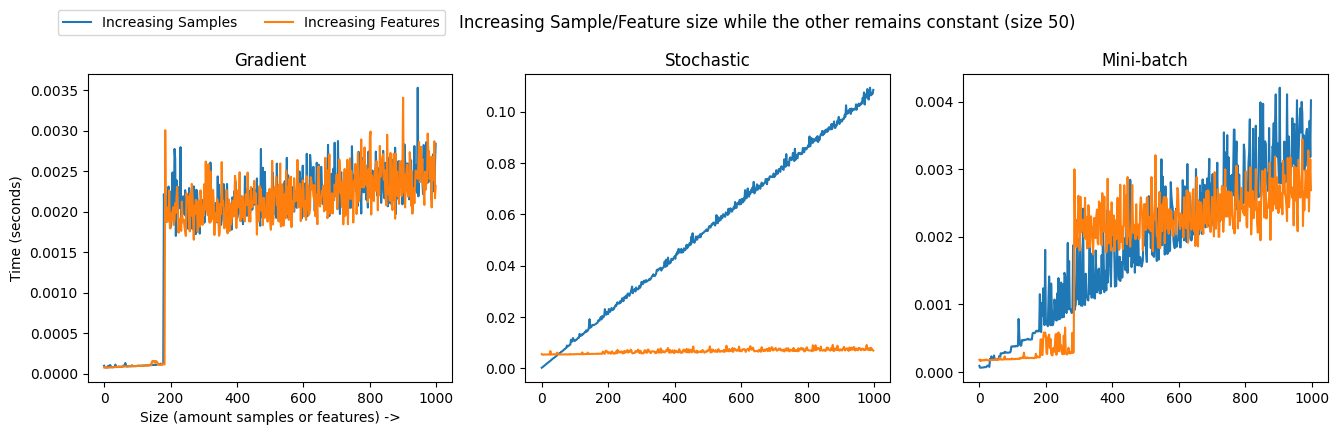

In [14]:
stop  = 1000
step  = 2

learning_rate = 0.1
epochs = 10

samples  = [i for i in range(1, stop, step)]
features = [i for i in range(1, stop, step)]

algorithm_comparison(samples, features, stop, learning_rate, epochs);

In [52]:
from functools import wraps

def memoize(func):
    cache = {}

    @wraps(func)
    def wrapper(*args, **kwargs):
        key = str(args) + str(kwargs)

        if key not in cache:
            cache[key] = func(*args, **kwargs)

        return cache[key]
    return wrapper

@memoize
def fast_gradient_descent(X, y, learning_rate, epochs):
    return gradient_descent(X, y, learning_rate, epochs)

In [53]:
X, y = simulate_dataset(100, 100, beta_values = [1] * (100 + 1))

In [137]:
time1 = 0
time2 = 0
repeats = 0
repeats_per_run = 25

In [147]:
repeats += repeats_per_run

# time first method
start1 = timeit.default_timer()

for i in range(repeats_per_run):
    gradient_descent(X, y, learning_rate = 0.01, epochs = 1000)

time1 += (timeit.default_timer() - start1) / repeats

# time second method
start2 = timeit.default_timer()

for i in range(repeats_per_run):
    fast_gradient_descent(X, y, learning_rate = 0.01, epochs = 1000)

time2 += (timeit.default_timer() - start2) / repeats

difference = max((time1, time2)) / min((time1, time2))
percentage = ((max((time1, time2)) - min((time1, time2))) / max((time1, time2))) * 100

if time1 < time2:
    print(f"Normal gradient descent was {percentage:.1f} % ({difference:.0f} times) faster than fast gradient descent")
else:
    print(f"Fast gradient descent was {percentage:.1f} % ({difference:.0f} times) faster than normal gradient descent")
print(f"{(time1 / repeats) * 1000 :.2f} ms vs {(time2 / repeats) * 1000:.2f} ms average after {repeats} repeats")

Fast gradient descent was 99.6 % (234 times) faster than normal gradient descent
2.25 ms vs 0.01 ms average after 250 repeats
